## **Trend Following Strategy Backtest**

This notebook conducts a backtest of a trend-following strategy using historical market data. The objective is to evaluate the strategy’s performance across different volatility environments and time frames, offering insight into its robustness and adaptability under varying market conditions.


## Imports:

| Library      | Purpose                              |
|--------------|--------------------------------------|
| Backtrader   | Used as the backtesting engine       |
| Yfinance     | Handles historical data retrieval    |
| Matplotlib   | Used for plotting results            |
| Pandas       | For general data handling            |




In [76]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('TkAgg')
%matplotlib inline

import backtrader as bt
import yfinance as yf
import pandas as pd
import seaborn as sns
import numpy as np

### Strategy Class Definition

We create a custom strategy class, `VMomentumStrategy`, that implements a trend-following logic based on momentum and a simple moving average (SMA). The strategy goes long when short-term momentum is stronger than long-term momentum and the price is above the SMA. 

It also includes take profit and stop loss rules, and tracks key performance metrics such as total trades, win rate, expectancy, and average PnL per trade.


In [77]:
# Strategy class
class VMomentumStrategy(bt.Strategy):
    params = (
        ('mom_short_period', None),   # period for short momentum calculation
        ('mom_long_period', None),   # period for long momentum calculation
        ('sma_period', None),        # SMA period for trend confirmation
        ('tp_perc', None),         # take profit in %
        ('sl_perc', None),          # stop loss in %
    )

    def __init__(self):
        # Indicators
        self.short_mom = bt.ind.Momentum(period=self.p.mom_short_period)
        self.long_mom = bt.ind.Momentum(period=self.p.mom_long_period)
        self.sma = bt.ind.SMA(period=self.p.sma_period)

        self.order = None  # To track ongoing orders
        self.entry_price = None
    
        # Metrics
        self.total_trades = 0
        self.wins = 0
        self.losses = 0
        self.pnl_wins = []
        self.pnl_losses = []

    def next(self):
        if self.order:
            return

        if not self.position:
            if self.short_mom > self.long_mom and self.data.close[0] > self.sma[0]:
                size = int((self.broker.get_cash()*0.95) // self.data.close[0])

                if size >0:
                    self.order = self.buy(size= size)
                    self.entry_price = self.data.close[0]
        
        if self.position:
            if self.short_mom < self.long_mom or self.data.close[0] < self.sma[0]:
                self.order = self.sell(size= self.position.size)
            else:
                gain = (self.data.close[0] - self.entry_price) / self.entry_price * 100
                if gain >= self.p.tp_perc or gain <= -self.p.sl_perc:
                    self.sell(size= self.position.size)

    def notify_order(self, order):
        if order.status in [order.Completed, order.Canceled, order.Rejected]:
            self.order = None

    def notify_trade(self, trade):
        if trade.isclosed:
            pnl = trade.pnlcomm
            self.total_trades += 1

            if pnl > 0:
                self.wins += 1
                self.pnl_wins.append(pnl)
            else:
                self.losses += 1
                self.pnl_losses.append(abs(pnl))  # use abs for expectancy calc

    def stop(self):
        self.start_value = self.broker.startingcash
        self.end_value = self.broker.getvalue()
        self.pct_return = ((self.end_value - self.start_value) / self.start_value) * 100

        self.win_rate = (self.wins / self.total_trades) * 100 if self.total_trades else 0
        self.avg_win = sum(self.pnl_wins) / len(self.pnl_wins) if self.pnl_wins else 0
        self.avg_loss = sum(self.pnl_losses) / len(self.pnl_losses) if self.pnl_losses else 0
        self.loss_rate = 1 - (self.wins / self.total_trades) if self.total_trades else 0
        self.expectancy = (self.win_rate / 100) * self.avg_win - self.loss_rate * self.avg_loss

        print("\n=== Portfolio Value ===")
        print(f'Starting Portfolio Value: {self.start_value}')
        print(f'Final Portfolio Value   : {self.end_value}')
        print("\n=== Strategy Performance ===")
        print(f"Return %         : {self.pct_return:.2f}%")
        print(f"Total Trades     : {self.total_trades}")
        print(f"Win Rate         : {self.win_rate:.2f}%")
        print(f"Expectancy       : {self.expectancy:.2f}")
        print(f"Avg Win          : {self.avg_win:.2f}")
        print(f"Avg Loss         : {self.avg_loss:.2f}")

## Backtest Function

We define a function `run_backtest` that fetches historical data using the yfinance library, prepares it for the Backtrader engine, and executes a backtest using the `VMomentumStrategy` class.


📥 Parameters:

- symbol (str): Stock ticker (e.g., 'TSLA').

- interval (str): Data interval (e.g., '1h', '1d'). Default is '1h'.

- period (str): Length of historical data (e.g., '6mo', '1y'). Default is '6mo'.

📤 **Returns**:

- Prints backtest resuts including strategy performance and risk metrics.


In [78]:
# BackTest Function
def run_backtest(symbol: str, interval: str = '1h', period: str = '6mo', strategy_params: dict = None, plot: bool = True):
    # Download data using yfinance with period and interval
    data = yf.download(tickers=symbol, interval=interval, period=period)

    # Check if data was retrieved
    if data.empty:
        print("No data retrieved. Please check the parameters.")
        return

    # Clean and rename DataFrame to match Backtrader's expectations
    data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
    data.columns = ['open', 'high', 'low', 'close', 'volume']
    data.index.name = 'datetime'  # Backtrader expects datetime index
    print(f'Data Count: {len(data)}')
    print(f' \n*********  STARTING BACKTEST FOR {symbol}  *********')

    # Create a backtest Cerebro
    cerebro = bt.Cerebro()

    # Add strategy with parameters if provided
    if strategy_params is None:
        strategy_params = {}
    cerebro.addstrategy(VMomentumStrategy, **strategy_params)

    cerebro.broker.setcash(100000)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')

    # Add data feed
    bt_data = bt.feeds.PandasData(dataname=data)
    cerebro.adddata(bt_data)

    # Run backtest and get results
    results = cerebro.run()
    strat = results[0]
    sharpe_ratio = strat.analyzers.sharpe.get_analysis()['sharperatio']
    drawdown = strat.analyzers.drawdown.get_analysis()['max']['drawdown']
    print("\n=== Risk Metrics ===")
    print('Sharpe Ratio:', strat.analyzers.sharpe.get_analysis()['sharperatio'])
    print('Max Drawdown:', strat.analyzers.drawdown.get_analysis()['max']['drawdown'])

    if plot:
        cerebro.plot(style='candlestick', iplot=False)
    
    return {
        'Symbol': symbol,
        'Return %': strat.pct_return,
        'Total Trades': strat.total_trades,
        'Win Rate': strat.win_rate,
        'Expectancy': strat.expectancy,
        'Avg Win': strat.avg_win,
        'Avg Loss': strat.avg_loss,
        'sharpe ratio': sharpe_ratio,
        'drawdown': drawdown,
    }


## Volatility Check Function

We create a function `check_volatility` to evaluate how volatile the returns of a stock has been over a given historical period. It computes the percentage change in closing prices, and calculates the standard deviation of these returns — which serves as a proxy for volatility.

📥 **Parameters**:

- symbol (str): Stock ticker symbol (e.g., 'TSLA').
- interval (str): Time interval for data points (e.g., '1d', '1h'). Default is '1d'.
- period (str): Time span for historical data (e.g., '6mo', '1y'). Default is '6mo'.

📤 **Returns**:

- Prints and returns the standard deviation of daily (or chosen interval) returns — a basic measure of volatility.



In [79]:
# Volatility Check
def check_volatility(symbol: list, interval: str = '1h', period: str = '6mo'):
    """
    Fetches historical data for multiple tickers in one call,
    calculates volatility (std dev of daily returns) for each ticker,
    and returns a DataFrame with volatility per symbol.
    """
    # Download Close prices for all symbols in one call
    data = yf.download(tickers=symbols, interval=interval, period=period)['Close']

    # Calculate daily returns for each ticker
    returns = data.pct_change().dropna()

    # Calculate volatility (std dev of returns) per ticker
    volatility = returns.std()

    return volatility.to_frame(name='volatility')



## Defining a List of Stocks for Backtest

We construct a diverse list of stocks and ETFs spanning various sectors, market caps, and volatility profiles. The selection includes stable large-cap names, high-growth tech stocks, defensive consumer staples, and broad market ETFs. The objective is to evaluate strategy performance under different market conditions and volatility regimes. 


In [80]:
symbols = [
    # Tech & Large Cap (Mix of Volatility)
    'AAPL',    # Apple Inc. - Technology, large cap, moderate volatility
    'TSLA',    # Tesla Inc. - Automotive/Tech, high volatility growth
    'MSFT',    # Microsoft Corp. - Technology, stable large cap
    'AMZN',    # Amazon.com Inc. - E-commerce/Cloud, growth, moderate-high volatility
    'NVDA',    # Nvidia Corp. - Semiconductors, very high volatility growth
    'GOOGL',   # Alphabet Inc. (Class A) - Tech/Internet, large cap, moderate
    'META',    # Meta Platforms - Social Media/Tech, higher volatility
    'NFLX',    # Netflix - Streaming Media, high volatility

    # Financials (Mix of Stability and Growth)
    'JPM',     # JPMorgan Chase - Banking, large cap, moderate volatility
    'BAC',     # Bank of America - Banking, large cap, moderate volatility
    'GS',      # Goldman Sachs - Investment Banking, moderate-high volatility
    'BLK',     # BlackRock - Asset Management, moderate volatility
    'V',       # Visa - Payments, moderate volatility
    'MA',      # Mastercard - Payments, moderate volatility

    # Healthcare (Mix of Stability and Growth)
    'PFE',     # Pfizer - Pharmaceuticals, moderate volatility
    'JNJ',     # Johnson & Johnson - Pharmaceuticals/Healthcare, stable, low volatility
    'LLY',     # Eli Lilly and Company - Pharmaceuticals, growth (due to recent drugs), higher volatility
    'UNH',     # UnitedHealth Group - Health Insurance, stable
    'ABBV',    # AbbVie - Biopharmaceuticals, moderate volatility

    # Consumer Defensive (Lower Volatility)
    'KO',      # Coca-Cola - Beverages, low volatility
    'MCD',     # McDonald's - Fast Food, low volatility
    'WMT',     # Walmart - Retail, low volatility
    'PG',      # Procter & Gamble - Consumer Goods, very low volatility
    'PEP',     # PepsiCo - Beverages/Snacks, low volatility

    # Consumer Discretionary (Mixed Volatility)
    'DIS',     # Disney - Entertainment, moderate volatility
    'HD',      # Home Depot - Home Improvement Retail, moderate volatility
    'NKE',     # Nike - Apparel, moderate volatility
    'SBUX',    # Starbucks - Coffee, moderate volatility

    # Industrials (Mixed Volatility)
    'BA',      # Boeing - Aerospace & Defense, can be volatile
    'CAT',     # Caterpillar - Construction/Mining Equipment, cyclical, moderate volatility
    'GE',      # General Electric - Industrial Conglomerate, often volatile
    'LMT',     # Lockheed Martin - Aerospace & Defense, stable

    # Energy (Mixed Volatility, commodity-linked)
    'XOM',     # Exxon Mobil - Oil & Gas, typically lower volatility for energy
    'CVX',     # Chevron - Oil & Gas, typically lower volatility for energy
    'OXY',     # Occidental Petroleum - Oil & Gas, can be higher volatility

    # Materials (Cyclical)
    'FCX',     # Freeport-McMoRan - Copper Mining, volatile (commodity linked)
    'LIN',     # Linde PLC - Industrial Gases, more stable

    # Utilities (Low Volatility)
    'NEE',     # NextEra Energy - Electric Utility, typically low volatility

    # Real Estate (Often moderate volatility)
    'SPG',     # Simon Property Group - Retail REIT, moderate volatility

    # High Growth / Speculative (Higher Volatility)
    'PLTR',    # Palantir - Technology Services and AI - very high volatility
    'SOFI',    # FinTech - very high volatility
    'HOOD',    # Robinhood Markets - Financial Services, high volatility
    'RKLB',    # Rocket Lab USA - Aerospace, high volatility
    'LUNR',    # Intuitive Machines - Space Exploration, very high volatility
    'PYPL',    # PayPal - Fintech, high volatility

    # 10 Major ETFs (not VIX-related, broad market & sector-specific)
    'SPY',     # S&P 500 ETF - Broad Market (Large Cap)
    'QQQ',     # Nasdaq 100 ETF - Technology Heavy (Growth)
    'DIA',     # Dow Jones Industrial Average ETF - Blue Chip Large Cap
    'IWM',     # Russell 2000 ETF - Small Cap, higher volatility
    'GLD',     # SPDR Gold Shares - Gold (Commodity, defensive)
    'XLF',     # Financial Select Sector SPDR Fund - Financial Sector
    'XLK',     # Technology Select Sector SPDR Fund - Technology Sector
    'XLE',     # Energy Select Sector SPDR Fund - Energy Sector
    'VNQ',     # Vanguard Real Estate ETF - Real Estate Sector
    'VOO',     # Vanguard S&P 500 ETF (alternative to SPY, slightly lower expense ratio)
]


## Categorizing Stocks by Volatility

We define a function to classify stocks into high, medium, and low volatility groups based on their historical standard deviation. The categorization is done using the 30th and 80th percentiles as thresholds.

This allows us to analyze strategy performance across different volatility environments. Each group is returned as a dictionary and printed for verification.


In [81]:
def categorize_volatility(volatility_df):
    """
    Categorizes tickers based on volatility percentiles into high, medium, and low buckets.
    Returns dictionaries of symbol: volatility.
    """
    high_vol = {}
    medium_vol = {}
    low_vol = {}

    # Calculate thresholds
    vols = volatility_df['volatility']
    low_thresh = vols.quantile(0.30)
    high_thresh = vols.quantile(0.80)

    print(f"Low Volatility threshold: {low_thresh:.4f}, High Volatility threshold: {high_thresh:.4f}")

    # Categorize
    for symbol, row in volatility_df.iterrows():
        vol = row['volatility']
        if vol > high_thresh:
            high_vol[symbol] = vol
        elif vol > low_thresh:
            medium_vol[symbol] = vol
        else:
            low_vol[symbol] = vol

    # Debug output
    print("🟥 High Volatility:", high_vol.keys())
    print("🟨 Medium Volatility:", medium_vol.keys())
    print("🟩 Low Volatility:", low_vol.keys())

    return high_vol, medium_vol, low_vol


## Creating Volatility Bins (High, Medium, and Low Groups)

To begin the backtest process, we analyze the volatility of each stock using a 6-month lookback period with 1-hour intervals. This is done via the `analyze_volatility()` function, which leverages previously defined volatility functions to compute standard deviation for each symbol and classify them into **High**, **Medium**, and **Low** volatility groups.

Each group is printed along with its corresponding tickers and standard deviation values. These volatility bins help us tailor strategy parameters based on different market regimes.

You can easily adjust the analysis window by modifying the `interval` and `period` parameters in the function call.


In [82]:
def analyze_volatility(symbols = symbols, interval='1h', period='6mo'):
    
    print(f"Total symbols in list: {len(symbols)}")

    vol_df = check_volatility(symbols, interval, period)

    high_vol, medium_vol, low_vol = categorize_volatility(vol_df)

    print("\n🔴 High Volatility:")
    for s, v in high_vol.items():
        print(f'{s} Standard Deviation: {round(v,3)}')

    print("\n🟠 Medium Volatility:")
    for s, v in medium_vol.items():
        print(f'{s} Standard Deviation: {round(v,3)}')

    print("\n🟢 Low Volatility:")
    for s, v in low_vol.items():
        print(f'{s} Standard Deviation: {round(v,3)}')
    
    return vol_df, high_vol, medium_vol, low_vol

analyze_volatility()

Total symbols in list: 55


[*********************100%***********************]  55 of 55 completed

Low Volatility threshold: 0.0065, High Volatility threshold: 0.0104
🟥 High Volatility: dict_keys(['BA', 'FCX', 'HOOD', 'LUNR', 'NKE', 'NVDA', 'PLTR', 'RKLB', 'SOFI', 'TSLA', 'UNH'])
🟨 Medium Volatility: dict_keys(['AAPL', 'ABBV', 'AMZN', 'BAC', 'BLK', 'CAT', 'CVX', 'DIS', 'GE', 'GOOGL', 'GS', 'IWM', 'JPM', 'LLY', 'LMT', 'META', 'MSFT', 'NEE', 'NFLX', 'OXY', 'PYPL', 'QQQ', 'SBUX', 'SPG', 'XLE', 'XLK', 'XOM'])
🟩 Low Volatility: dict_keys(['DIA', 'GLD', 'HD', 'JNJ', 'KO', 'LIN', 'MA', 'MCD', 'PEP', 'PFE', 'PG', 'SPY', 'V', 'VNQ', 'VOO', 'WMT', 'XLF'])

🔴 High Volatility:
BA Standard Deviation: 0.011
FCX Standard Deviation: 0.012
HOOD Standard Deviation: 0.021
LUNR Standard Deviation: 0.031
NKE Standard Deviation: 0.011
NVDA Standard Deviation: 0.014
PLTR Standard Deviation: 0.021
RKLB Standard Deviation: 0.024
SOFI Standard Deviation: 0.017
TSLA Standard Deviation: 0.017
UNH Standard Deviation: 0.014

🟠 Medium Volatility:
AAPL Standard Deviation: 0.009
ABBV Standard Deviation: 0.007
AMZN 

(        volatility
 Ticker            
 AAPL      0.008627
 ABBV      0.007076
 AMZN      0.009616
 BA        0.010929
 BAC       0.008501
 BLK       0.007813
 CAT       0.008192
 CVX       0.006894
 DIA       0.004970
 DIS       0.008140
 FCX       0.012186
 GE        0.008089
 GLD       0.004514
 GOOGL     0.008793
 GS        0.009509
 HD        0.006456
 HOOD      0.020810
 IWM       0.006907
 JNJ       0.005139
 JPM       0.007410
 KO        0.004685
 LIN       0.004898
 LLY       0.009904
 LMT       0.007040
 LUNR      0.031009
 MA        0.005802
 MCD       0.005227
 META      0.010349
 MSFT      0.007289
 NEE       0.007565
 NFLX      0.009415
 NKE       0.010841
 NVDA      0.013943
 OXY       0.010131
 PEP       0.005442
 PFE       0.006318
 PG        0.005026
 PLTR      0.020696
 PYPL      0.009199
 QQQ       0.006750
 RKLB      0.023894
 SBUX      0.009052
 SOFI      0.016708
 SPG       0.008203
 SPY       0.005581
 TSLA      0.017115
 UNH       0.013553
 V         0.005604


## Parameter Sets by Volatility Group

We define parameter sets for each volatility bin: `high`,   `medium`, and   `low` to capture the behavioral differences between


In [83]:
# Parameters for High Volatility Stocks
params_high_vol = {
    'mom_short_period': 7,   # A longer short-term momentum period to smooth out rapid price fluctuations and reduce false signals in highly volatile environments.
    'mom_long_period': 14,   # A longer-term momentum baseline to compare against short-term shifts, helping confirm sustained trends.
    'sma_period': 18,        # A moderately short SMA to follow price action closely without reacting to every spike.
    'tp_perc': 5.0,          # A more aggressive take-profit level to capitalize on larger price swings that are typical in high volatility.
    'sl_perc': 2.5,          # A wider stop-loss to avoid getting stopped out by normal noise or temporary spikes in volatile stocks.
}

# Parameters for Medium Volatility Stocks
params_medium_vol = {
    'mom_short_period': 4,   # A moderate short-term momentum period to capture meaningful shifts without overreacting.
    'mom_long_period': 10,   # Balanced long-term momentum for comparison to short-term movements.
    'sma_period': 22,        # A slightly longer SMA to smooth price action moderately, fitting the typical behavior of medium-volatility stocks.
    'tp_perc': 1.75,         # A balanced take-profit level to lock in gains while still allowing room for trends to develop.
    'sl_perc': 1.0,          # A moderate stop-loss that gives trades breathing room without risking large losses.
}

# Parameters for Low Volatility Stocks
params_low_vol = {
    'mom_short_period': 3,   # A short momentum trigger to increase sensitivity and react faster to subtle price changes.
    'mom_long_period': 9,    # A relatively shorter long-term momentum setting to remain responsive in a calm market.
    'sma_period': 30,        # A longer SMA to provide strong trend confirmation and filter out minor movements in low-volatility environments.
    'tp_perc': 0.75,         # A conservative take-profit level, matching the typical smaller moves in low-volatility stocks.
    'sl_perc': 0.5,          # A tight stop-loss, appropriate for low-volatility assets with minimal noise.
}


## Running the Backtests Across Volatility Groups

Many tasks are performed here—this is the core execution block. We create and call a backtest pipeline, then present the results in a user-friendly and readable format. Let’s walk through it step by step:

🔍 **Step 1: Display Volatility Group Breakdown for Visual Inspection**  
We print out the number of tickers and their symbols, grouped by volatility. This gives us a clear view of what we're working with.

🔄 **Step 2: Define and Run the Backtest Pipeline**  
We define a `process_group` function that does the heavy lifting:

* Iterates through each ticker in a volatility group
* Runs a backtest using the corresponding strategy parameters
* Collects successful results into a DataFrame for later analysis

🚀 **Step 3: Execute Backtests for Each Group**  
We call `process_group` three times—once for each volatility class: High, Medium, and Low.

📌 **Step 4: Print Execution Summary**  
While processing stocks, we print out the individual results for each ticker as they are completeted, then log how many backtests were successfully completed for a quick verification.

📊 **Step 5: Combine and Review Results**  
We merge all single-row DataFrames into a master table and sort the results by expectancy, making it easy to spot top performers.

📉 **Step 6: Visualize Performance by Volatility Group**  
Finally, we generate a bar plot to visualize expectancy by ticker and volatility group. This lets us quickly compare strategy performance across different market conditions.

📌 **Step 7: Final Quality Check**  
We assess the global quality of all completed backtests by checking how many had:

* Positive Total Return

* Positive Expectancy

* Sharpe Ratio above 1.0

This gives a concise overview of how many strategies not only ran successfully but also met a reasonable performance standard.




🔴 High Volatility (11 stocks): ['BA', 'FCX', 'HOOD', 'LUNR', 'NKE', 'NVDA', 'PLTR', 'RKLB', 'SOFI', 'TSLA', 'UNH']
🟠 Medium Volatility (27 stocks): ['AAPL', 'ABBV', 'AMZN', 'BAC', 'BLK', 'CAT', 'CVX', 'DIS', 'GE', 'GOOGL', 'GS', 'IWM', 'JPM', 'LLY', 'LMT', 'META', 'MSFT', 'NEE', 'NFLX', 'OXY', 'PYPL', 'QQQ', 'SBUX', 'SPG', 'XLE', 'XLK', 'XOM']
🟢 Low Volatility (17 stocks): ['DIA', 'GLD', 'HD', 'JNJ', 'KO', 'LIN', 'MA', 'MCD', 'PEP', 'PFE', 'PG', 'SPY', 'V', 'VNQ', 'VOO', 'WMT', 'XLF']

High Volatility Stocks
------------------------------


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR BA  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 96567.23606872559

=== Strategy Performance ===
Return %         : -3.43%
Total Trades     : 52
Win Rate         : 48.08%
Expectancy       : -66.01
Avg Win          : 1234.20
Avg Loss         : 1269.91

=== Risk Metrics ===
Sharpe Ratio: -0.4687933378637498
Max Drawdown: 18.56470220313309


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR FCX  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 96324.57298851013

=== Strategy Performance ===
Return %         : -3.68%
Total Trades     : 51
Win Rate         : 43.14%
Expectancy       : -72.07
Avg Win          : 1593.61
Avg Loss         : 1335.69

=== Risk Metrics ===
Sharpe Ratio: -1.091919120999238
Max Drawdown: 11.052563983917237


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR HOOD  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 130589.61312484741

=== Strategy Performance ===
Return %         : 30.59%
Total Trades     : 19
Win Rate         : 73.68%
Expectancy       : 1609.98
Avg Win          : 2611.04
Avg Loss         : 1193.00

=== Risk Metrics ===
Sharpe Ratio: 1.0610684775983006
Max Drawdown: 5.512831891208965


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR LUNR  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 96125.4977478981

=== Strategy Performance ===
Return %         : -3.87%
Total Trades     : 39
Win Rate         : 38.46%
Expectancy       : -99.35
Avg Win          : 3848.10
Avg Loss         : 2566.50

=== Risk Metrics ===
Sharpe Ratio: -1.0316688792637558
Max Drawdown: 16.03318332631367


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR NKE  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 94931.42949295044

=== Strategy Performance ===
Return %         : -5.07%
Total Trades     : 57
Win Rate         : 40.35%
Expectancy       : -88.92
Avg Win          : 1113.92
Avg Loss         : 902.61

=== Risk Metrics ===
Sharpe Ratio: -0.6552323791259625
Max Drawdown: 11.956253640261775


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR NVDA  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 92484.87637329102

=== Strategy Performance ===
Return %         : -7.52%
Total Trades     : 27
Win Rate         : 29.63%
Expectancy       : -278.34
Avg Win          : 1652.96
Avg Loss         : 1091.51

=== Risk Metrics ===
Sharpe Ratio: -5.363676578845322
Max Drawdown: 8.456641290143203


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR PLTR  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 113707.60526275635

=== Strategy Performance ===
Return %         : 13.71%
Total Trades     : 37
Win Rate         : 56.76%
Expectancy       : 370.48
Avg Win          : 2473.16
Avg Loss         : 2389.30

=== Risk Metrics ===
Sharpe Ratio: 4.2527485328845085
Max Drawdown: 15.673193443803202


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR RKLB  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 145602.1027317047

=== Strategy Performance ===
Return %         : 45.60%
Total Trades     : 42
Win Rate         : 47.62%
Expectancy       : 1085.76
Avg Win          : 4873.38
Avg Loss         : 2357.53

=== Risk Metrics ===
Sharpe Ratio: 1.9503599735745103
Max Drawdown: 14.20828716726454


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR SOFI  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 117568.14725780487

=== Strategy Performance ===
Return %         : 17.57%
Total Trades     : 26
Win Rate         : 57.69%
Expectancy       : 675.70
Avg Win          : 2414.34
Avg Loss         : 1695.18

=== Risk Metrics ===
Sharpe Ratio: 0.9680062143726208
Max Drawdown: 6.431629418196134


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR TSLA  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 101206.69909667969

=== Strategy Performance ===
Return %         : 1.21%
Total Trades     : 49
Win Rate         : 42.86%
Expectancy       : 24.63
Avg Win          : 2557.22
Avg Loss         : 1874.82

=== Risk Metrics ===
Sharpe Ratio: -0.00291388689593079
Max Drawdown: 18.10641623339609


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR UNH  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 98224.79711914062

=== Strategy Performance ===
Return %         : -1.78%
Total Trades     : 50
Win Rate         : 46.00%
Expectancy       : -16.35
Avg Win          : 709.86
Avg Loss         : 634.97

=== Risk Metrics ===
Sharpe Ratio: -1.6797468599711374
Max Drawdown: 5.896738689947513

Medium Volatility Stocks
------------------------------


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR AAPL  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 117367.97286987305

=== Strategy Performance ===
Return %         : 17.37%
Total Trades     : 49
Win Rate         : 61.22%
Expectancy       : 347.77
Avg Win          : 918.87
Avg Loss         : 553.98

=== Risk Metrics ===
Sharpe Ratio: 1.0085602681719537
Max Drawdown: 2.7194278543957404


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR ABBV  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 98782.92993164062

=== Strategy Performance ===
Return %         : -1.22%
Total Trades     : 17
Win Rate         : 35.29%
Expectancy       : -71.59
Avg Win          : 390.48
Avg Loss         : 323.63

=== Risk Metrics ===
Sharpe Ratio: -1.9478969008028038
Max Drawdown: 1.9228975819478882


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR AMZN  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 92579.29357910156

=== Strategy Performance ===
Return %         : -7.42%
Total Trades     : 55
Win Rate         : 40.00%
Expectancy       : -134.92
Avg Win          : 1219.78
Avg Loss         : 1038.05

=== Risk Metrics ===
Sharpe Ratio: -1.30367191256473
Max Drawdown: 11.551676350642811


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR BAC  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 102108.53273773193

=== Strategy Performance ===
Return %         : 2.11%
Total Trades     : 67
Win Rate         : 46.27%
Expectancy       : 31.47
Avg Win          : 643.34
Avg Loss         : 495.42

=== Risk Metrics ===
Sharpe Ratio: 0.06191010181353623
Max Drawdown: 4.830605445980992


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR BLK  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 108398.49249267578

=== Strategy Performance ===
Return %         : 8.40%
Total Trades     : 57
Win Rate         : 52.63%
Expectancy       : 147.34
Avg Win          : 801.40
Avg Loss         : 579.39

=== Risk Metrics ===
Sharpe Ratio: 1.0263291176984266
Max Drawdown: 4.049119818389961


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR CAT  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 97743.02554321289

=== Strategy Performance ===
Return %         : -2.26%
Total Trades     : 55
Win Rate         : 43.64%
Expectancy       : -41.04
Avg Win          : 872.45
Avg Loss         : 748.25

=== Risk Metrics ===
Sharpe Ratio: -1.0134521901322555
Max Drawdown: 6.2443126090350995


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR CVX  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 96074.70137023926

=== Strategy Performance ===
Return %         : -3.93%
Total Trades     : 57
Win Rate         : 49.12%
Expectancy       : -64.65
Avg Win          : 409.67
Avg Loss         : 522.62

=== Risk Metrics ===
Sharpe Ratio: -6.714346145253185
Max Drawdown: 5.577080134624376


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR DIS  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 103350.95375061035

=== Strategy Performance ===
Return %         : 3.35%
Total Trades     : 64
Win Rate         : 51.56%
Expectancy       : 52.36
Avg Win          : 709.70
Avg Loss         : 647.39

=== Risk Metrics ===
Sharpe Ratio: 0.580999365941389
Max Drawdown: 8.112834897271254


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR GE  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 106717.28497314453

=== Strategy Performance ===
Return %         : 6.72%
Total Trades     : 55
Win Rate         : 52.73%
Expectancy       : 127.34
Avg Win          : 790.71
Avg Loss         : 612.58

=== Risk Metrics ===
Sharpe Ratio: 0.8496937811764923
Max Drawdown: 3.291717951644891


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR GOOGL  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 100522.35675048828

=== Strategy Performance ===
Return %         : 0.52%
Total Trades     : 53
Win Rate         : 52.83%
Expectancy       : 9.86
Avg Win          : 741.47
Avg Loss         : 809.55

=== Risk Metrics ===
Sharpe Ratio: -0.9502078534792255
Max Drawdown: 8.218174516356806


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR GS  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 101596.7766418457

=== Strategy Performance ===
Return %         : 1.60%
Total Trades     : 58
Win Rate         : 48.28%
Expectancy       : 27.53
Avg Win          : 965.10
Avg Loss         : 847.53

=== Risk Metrics ===
Sharpe Ratio: -0.18143884964777382
Max Drawdown: 5.377364801835732


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR IWM  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 100671.15864562988

=== Strategy Performance ===
Return %         : 0.67%
Total Trades     : 54
Win Rate         : 53.70%
Expectancy       : 12.43
Avg Win          : 666.30
Avg Loss         : 746.06

=== Risk Metrics ===
Sharpe Ratio: -0.6502495102402832
Max Drawdown: 6.295899002929698


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR JPM  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 113728.00451660156

=== Strategy Performance ===
Return %         : 13.73%
Total Trades     : 60
Win Rate         : 61.67%
Expectancy       : 228.80
Avg Win          : 770.53
Avg Loss         : 642.68

=== Risk Metrics ===
Sharpe Ratio: 1.0992582602911394
Max Drawdown: 3.246420922645809


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR LLY  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 92762.33935546875

=== Strategy Performance ===
Return %         : -7.24%
Total Trades     : 57
Win Rate         : 45.61%
Expectancy       : -126.98
Avg Win          : 734.63
Avg Loss         : 849.62

=== Risk Metrics ===
Sharpe Ratio: -0.9424286967311775
Max Drawdown: 13.960237201437302


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR LMT  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 92834.60363769531

=== Strategy Performance ===
Return %         : -7.17%
Total Trades     : 54
Win Rate         : 48.15%
Expectancy       : -132.69
Avg Win          : 464.16
Avg Loss         : 686.92

=== Risk Metrics ===
Sharpe Ratio: -1.8266731660194202
Max Drawdown: 9.009595301281195


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR META  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 96625.87689208984

=== Strategy Performance ===
Return %         : -3.37%
Total Trades     : 48
Win Rate         : 41.67%
Expectancy       : -70.29
Avg Win          : 994.39
Avg Loss         : 830.78

=== Risk Metrics ===
Sharpe Ratio: -2.282456513632456
Max Drawdown: 7.778451572786158


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR MSFT  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 98211.3687133789

=== Strategy Performance ===
Return %         : -1.79%
Total Trades     : 43
Win Rate         : 46.51%
Expectancy       : -41.60
Avg Win          : 688.07
Avg Loss         : 676.09

=== Risk Metrics ===
Sharpe Ratio: -1.0675268112805467
Max Drawdown: 10.245215810006268


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR NEE  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 100822.09622192383

=== Strategy Performance ===
Return %         : 0.82%
Total Trades     : 46
Win Rate         : 45.65%
Expectancy       : 17.87
Avg Win          : 799.83
Avg Loss         : 638.98

=== Risk Metrics ===
Sharpe Ratio: -3.077325256419814
Max Drawdown: 7.543654296355772


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR NFLX  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 99838.90411376953

=== Strategy Performance ===
Return %         : -0.16%
Total Trades     : 65
Win Rate         : 44.62%
Expectancy       : -2.48
Avg Win          : 736.23
Avg Loss         : 597.55

=== Risk Metrics ===
Sharpe Ratio: -1.00793666769954
Max Drawdown: 5.683558438143561


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR OXY  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 97155.86157989502

=== Strategy Performance ===
Return %         : -2.84%
Total Trades     : 60
Win Rate         : 50.00%
Expectancy       : -47.40
Avg Win          : 670.89
Avg Loss         : 765.69

=== Risk Metrics ===
Sharpe Ratio: -5.279086185766609
Max Drawdown: 9.347545705103276


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR PYPL  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 96754.44054031372

=== Strategy Performance ===
Return %         : -3.25%
Total Trades     : 58
Win Rate         : 43.10%
Expectancy       : -55.96
Avg Win          : 731.06
Avg Loss         : 652.19

=== Risk Metrics ===
Sharpe Ratio: -0.9304589384978977
Max Drawdown: 6.227935305673342


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR QQQ  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 106384.12774658203

=== Strategy Performance ===
Return %         : 6.38%
Total Trades     : 56
Win Rate         : 53.57%
Expectancy       : 114.00
Avg Win          : 706.09
Avg Loss         : 569.17

=== Risk Metrics ===
Sharpe Ratio: 3.5079521732064354
Max Drawdown: 4.788827012513383


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR SBUX  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 108685.61898803711

=== Strategy Performance ===
Return %         : 8.69%
Total Trades     : 59
Win Rate         : 52.54%
Expectancy       : 147.21
Avg Win          : 986.43
Avg Loss         : 781.92

=== Risk Metrics ===
Sharpe Ratio: 2.489595374328346
Max Drawdown: 8.79262003103294


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR SPG  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 93719.86178588867

=== Strategy Performance ===
Return %         : -6.28%
Total Trades     : 70
Win Rate         : 42.86%
Expectancy       : -89.72
Avg Win          : 549.23
Avg Loss         : 568.93

=== Risk Metrics ===
Sharpe Ratio: -1.04780023948611
Max Drawdown: 8.330427669989545


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR XLE  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 101432.93856811523

=== Strategy Performance ===
Return %         : 1.43%
Total Trades     : 52
Win Rate         : 51.92%
Expectancy       : 27.56
Avg Win          : 633.90
Avg Loss         : 627.30

=== Risk Metrics ===
Sharpe Ratio: -0.13441679200144044
Max Drawdown: 5.757602106090901


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR XLK  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 98089.92306518555

=== Strategy Performance ===
Return %         : -1.91%
Total Trades     : 63
Win Rate         : 52.38%
Expectancy       : -30.32
Avg Win          : 639.73
Avg Loss         : 767.37

=== Risk Metrics ===
Sharpe Ratio: -1.8795612343786758
Max Drawdown: 10.255001135418043


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR XOM  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 98918.46938323975

=== Strategy Performance ===
Return %         : -1.08%
Total Trades     : 60
Win Rate         : 45.00%
Expectancy       : -18.03
Avg Win          : 555.45
Avg Loss         : 487.23

=== Risk Metrics ===
Sharpe Ratio: -1.8278696290814354
Max Drawdown: 5.455316642800193

Low Volatility Stocks
------------------------------


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR DIA  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 100422.16436767578

=== Strategy Performance ===
Return %         : 0.42%
Total Trades     : 58
Win Rate         : 43.10%
Expectancy       : 11.04
Avg Win          : 503.61
Avg Loss         : 362.12

=== Risk Metrics ===
Sharpe Ratio: -1.1144746593859627
Max Drawdown: 2.2026862496980133


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR GLD  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 103395.00350952148

=== Strategy Performance ===
Return %         : 3.40%
Total Trades     : 60
Win Rate         : 53.33%
Expectancy       : 56.58
Avg Win          : 426.40
Avg Loss         : 366.06

=== Risk Metrics ===
Sharpe Ratio: 0.5256210932218639
Max Drawdown: 5.411823430843901


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR HD  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 104773.87503051758

=== Strategy Performance ===
Return %         : 4.77%
Total Trades     : 59
Win Rate         : 45.76%
Expectancy       : 80.91
Avg Win          : 716.11
Avg Loss         : 455.03

=== Risk Metrics ===
Sharpe Ratio: 0.3149653060341837
Max Drawdown: 2.748796899556691


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR JNJ  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 102337.1371307373

=== Strategy Performance ===
Return %         : 2.34%
Total Trades     : 56
Win Rate         : 39.29%
Expectancy       : 41.73
Avg Win          : 633.10
Avg Loss         : 340.91

=== Risk Metrics ===
Sharpe Ratio: 0.06150694458983965
Max Drawdown: 2.9624040069580078


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR KO  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 104820.26667404175

=== Strategy Performance ===
Return %         : 4.82%
Total Trades     : 56
Win Rate         : 42.86%
Expectancy       : 86.08
Avg Win          : 662.64
Avg Loss         : 346.35

=== Risk Metrics ===
Sharpe Ratio: 0.34987160398630174
Max Drawdown: 2.907541038062698


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR LIN  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 100573.29763793945

=== Strategy Performance ===
Return %         : 0.57%
Total Trades     : 67
Win Rate         : 43.28%
Expectancy       : 6.20
Avg Win          : 410.17
Avg Loss         : 302.10

=== Risk Metrics ===
Sharpe Ratio: -0.9167717862922379
Max Drawdown: 5.221244184763906


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR MA  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 109450.77059936523

=== Strategy Performance ===
Return %         : 9.45%
Total Trades     : 66
Win Rate         : 53.03%
Expectancy       : 139.95
Avg Win          : 594.71
Avg Loss         : 373.50

=== Risk Metrics ===
Sharpe Ratio: 0.6664477995937107
Max Drawdown: 2.699683325800525


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR MCD  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 92837.70248413086

=== Strategy Performance ===
Return %         : -7.16%
Total Trades     : 60
Win Rate         : 33.33%
Expectancy       : -113.52
Avg Win          : 413.05
Avg Loss         : 376.80

=== Risk Metrics ===
Sharpe Ratio: -3.742211627813862
Max Drawdown: 7.392014495303715


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR PEP  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 97697.55409240723

=== Strategy Performance ===
Return %         : -2.30%
Total Trades     : 45
Win Rate         : 44.44%
Expectancy       : -51.17
Avg Win          : 447.29
Avg Loss         : 449.93

=== Risk Metrics ===
Sharpe Ratio: -2.3447356990685178
Max Drawdown: 4.405812377929688


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR PFE  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 97565.1309261322

=== Strategy Performance ===
Return %         : -2.43%
Total Trades     : 55
Win Rate         : 43.64%
Expectancy       : -44.27
Avg Win          : 548.48
Avg Loss         : 503.17

=== Risk Metrics ===
Sharpe Ratio: -7.355453602696688
Max Drawdown: 4.360464309431568


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR PG  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 104079.32363891602

=== Strategy Performance ===
Return %         : 4.08%
Total Trades     : 59
Win Rate         : 52.54%
Expectancy       : 69.14
Avg Win          : 454.53
Avg Loss         : 357.54

=== Risk Metrics ===
Sharpe Ratio: 0.30598401275959336
Max Drawdown: 3.147932727731826


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR SPY  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 106100.41491699219

=== Strategy Performance ===
Return %         : 6.10%
Total Trades     : 56
Win Rate         : 62.50%
Expectancy       : 112.55
Avg Win          : 432.47
Avg Loss         : 420.66

=== Risk Metrics ===
Sharpe Ratio: 0.7607101546374526
Max Drawdown: 2.5827175177141104


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR V  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 111059.30163574219

=== Strategy Performance ===
Return %         : 11.06%
Total Trades     : 67
Win Rate         : 49.25%
Expectancy       : 165.06
Avg Win          : 601.71
Avg Loss         : 258.74

=== Risk Metrics ===
Sharpe Ratio: 0.7969489865942698
Max Drawdown: 2.659483703787561


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR VNQ  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 97315.68659973145

=== Strategy Performance ===
Return %         : -2.68%
Total Trades     : 62
Win Rate         : 48.39%
Expectancy       : -41.96
Avg Win          : 431.31
Avg Loss         : 485.65

=== Risk Metrics ===
Sharpe Ratio: -3.6357595626050703
Max Drawdown: 4.744641349792481


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR VOO  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 105883.74719238281

=== Strategy Performance ===
Return %         : 5.88%
Total Trades     : 58
Win Rate         : 60.34%
Expectancy       : 105.56
Avg Win          : 433.30
Avg Loss         : 393.17

=== Risk Metrics ===
Sharpe Ratio: 0.8671698432579225
Max Drawdown: 2.5357935601478703


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR WMT  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 108816.18925476074

=== Strategy Performance ===
Return %         : 8.82%
Total Trades     : 68
Win Rate         : 54.41%
Expectancy       : 132.58
Avg Win          : 562.58
Avg Loss         : 380.66

=== Risk Metrics ===
Sharpe Ratio: 0.6233603430063454
Max Drawdown: 2.604266252446672


[*********************100%***********************]  1 of 1 completed


Data Count: 857
 
*********  STARTING BACKTEST FOR XLF  *********

=== Portfolio Value ===
Starting Portfolio Value: 100000
Final Portfolio Value   : 106532.36798858643

=== Strategy Performance ===
Return %         : 6.53%
Total Trades     : 54
Win Rate         : 51.85%
Expectancy       : 125.02
Avg Win          : 579.11
Avg Loss         : 364.01

=== Risk Metrics ===
Sharpe Ratio: 0.45558648026595483
Max Drawdown: 2.5522841415405275

📊 Backtest Summary:
   Symbol   Return %  Total Trades   Win Rate   Expectancy      Avg Win  \
2    HOOD  30.589613            19  73.684211  1609.979638  2611.042581   
7    RKLB  45.602103            42  47.619048  1085.764351  4873.383113   
8    SOFI  17.568147            26  57.692308   675.697971  2414.340853   
6    PLTR  13.707605            37  56.756757   370.475818  2473.159435   
11   AAPL  17.367973            49  61.224490   347.765814   918.874206   
23    JPM  13.728005            60  61.666667   228.800075   770.529288   
50      V  11.0

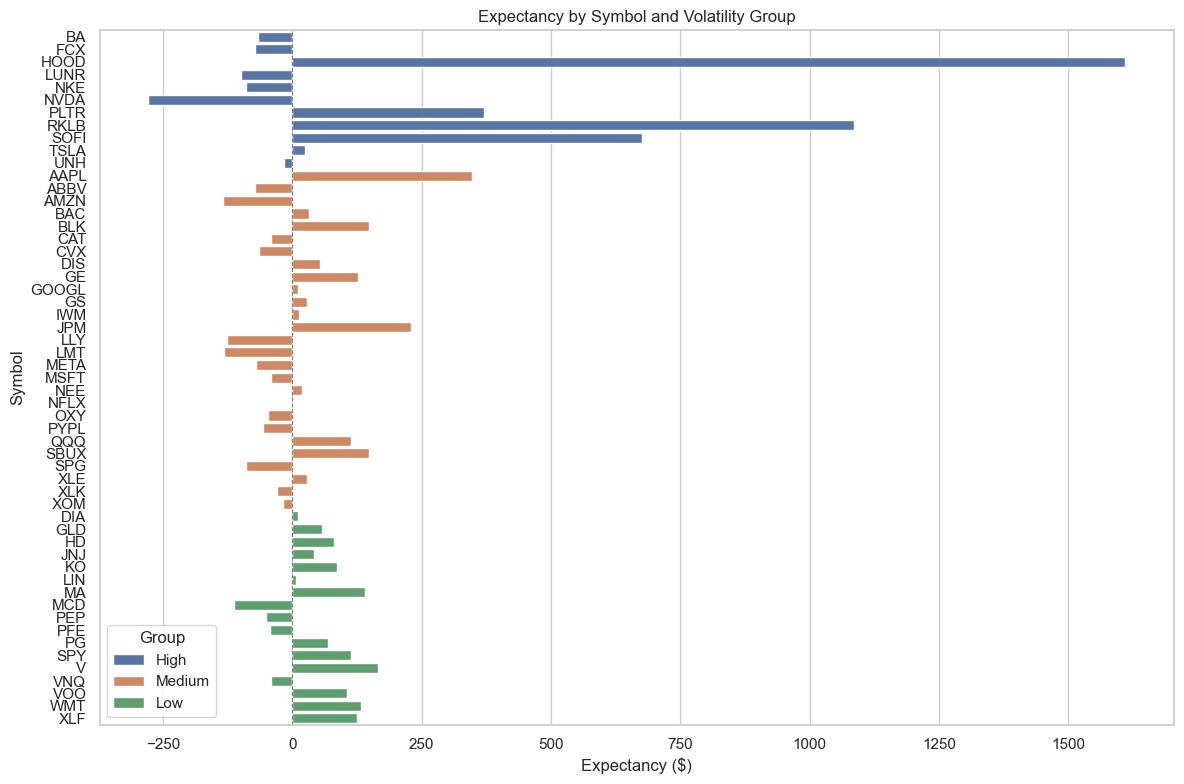


✅ Strategy Quality Summary:
🟢 31 backtests had positive total return out of 55
🟢 31 backtests had positive expectancy out of 55
🟢 8 backtests had Sharpe Ratio > 1.0 out of 55
🟢 Average Return: 2.89%
🟢 Max Total Return: 45.6%
🔴 Min Total Return: -7.52%
🔴 Max Drawdown: 18.56%
🔴 Average Drawdown: 6.87%


In [ ]:
results_all = []

def print_volatility_groups(high_vol, medium_vol, low_vol):
    print(f"\n🔴 High Volatility ({len(high_vol)} stocks): {list(high_vol.keys())}")
    print(f"🟠 Medium Volatility ({len(medium_vol)} stocks): {list(medium_vol.keys())}")
    print(f"🟢 Low Volatility ({len(low_vol)} stocks): {list(low_vol.keys())}")

def process_group(vol_group, group_name, strategy_params):
    group_results = []
    print(f"\n{group_name} Volatility Stocks\n" + "-"*30)
    for symbol, vol in vol_group.items():
        result = run_backtest(symbol, strategy_params=strategy_params, plot=False)
        if result is not None:
            result['Volatility'] = vol
            result['Group'] = group_name
            group_results.append(pd.DataFrame([result]))
        else:
            print(f'\n❌ No results for: {symbol}\n')
    return group_results

def run_full_backtest(high_vol, medium_vol, low_vol, params_high_vol, params_medium_vol, params_low_vol):
    print_volatility_groups(high_vol, medium_vol, low_vol)
    
    all_results = []
    all_results += process_group(high_vol, 'High', params_high_vol)
    all_results += process_group(medium_vol, 'Medium', params_medium_vol)
    all_results += process_group(low_vol, 'Low', params_low_vol)
    
    return pd.concat(all_results, ignore_index=True)

def summarize_results(df):
    total = len(df)
    pos_return = df[df['Return %'] > 0]
    pos_expect = df[df['Expectancy'] > 0]
    sharpe_gt_1 = df[df['sharpe ratio'] > 1]
    avg_return = round(df['Return %'].mean(), 2)
    max_return = round(df['Return %'].max(), 2)
    min_return = round(df['Return %'].min(), 2)
    max_dd = round(df['drawdown'].max(), 2)
    avg_dd = round(df['drawdown'].mean(), 2)
    
    print("\n✅ Final Quality & Performance Summary:")
    print(f"🟢 {len(pos_return)} backtests had positive total return out of {total}")
    print(f"🟢 {len(pos_expect)} backtests had positive expectancy out of {total}")
    print(f"🟢 {len(sharpe_gt_1)} backtests had Sharpe Ratio > 1.0 out of {total}")
    print(f"🟢 Average Return: {avg_return}%")
    print(f"🟢 Max Total Return: {max_return}%")
    print(f"🔴 Min Total Return: {min_return}%")
    print(f"🔴 Max Drawdown: {max_dd}%")
    print(f"🔴 Average Drawdown: {avg_dd}%")

def plot_expectancy(df):
    sns.set(style='whitegrid')
    plt.figure(figsize=(12, 8))
    sns.barplot(data=df, x='Expectancy', y='Symbol', hue='Group')
    plt.title("Expectancy by Symbol and Volatility Group")
    plt.xlabel("Expectancy ($)")
    plt.ylabel("Symbol")
    plt.axvline(0, color='grey', linestyle='--', linewidth=0.8)
    plt.tight_layout()
    plt.show()

# --- Run Backtests ---
df_results = run_full_backtest(high_vol, medium_vol, low_vol, params_high_vol, params_medium_vol, params_low_vol)

# --- Show Summary and Visuals ---
print("\n📊 Backtest Summary:")
print(df_results.sort_values(by='Expectancy', ascending=False))

plot_expectancy(df_results)
summarize_results(df_results)


## 📁 Save Results to CSV

Finally, we export the combined backtest results to a CSV file for future reference and external analysis. This ensures that the outputs can be revisited, shared, or used in further reporting.



In [85]:
#Step 1: Save Results to CSV
df_results.to_csv("backtest_results_volatility_groups.csv", index=False)
print("📁 Results saved to 'backtest_results_volatility_groups.csv'")


📁 Results saved to 'backtest_results_volatility_groups.csv'


## 🧾 **Can We Make Money with This Strategy?**

We've developed and evaluated a **trend-following trading strategy**, using a robust backtesting pipeline to quickly assess its performance across diverse stocks and varying market conditions. Our goal was to see if this strategy holds potential for profitability.

The strategy was first tested over a **6-month period** using **1-hour candles** across **55 different stocks**. This initial batch of backtests provided encouraging insights: over **55% of the analyzed stocks delivered positive returns**, with a standout high return of **45.6%**. The minimum return observed was a contained **-7.5%**, leading to an **average total return of 2.9%** across all backtests. While the maximum drawdown reached **19%**, the **mean drawdown was a well-contained 6.9%** over the analyzed period. These results offer **promising evidence of the strategy's potential viability**.

---

### ✅ Strategy Quality Summary (6-Month Period):

* **Positive Performance:**
    * **31 out of 55** backtests (56.4%) delivered a **positive total return**.
    * **31 out of 55** backtests (56.4%) showed a **positive expectancy**.
    * **8 out of 55** backtests (14.5%) achieved a **Sharpe Ratio greater than 1.0**, indicating strong risk-adjusted returns.

* **Return Metrics:**
    * The **average total return** across all 55 backtests was **2.9%**.
    * The **maximum total return** achieved in any single backtest was an impressive **45.6%**.
    * The **minimum total return** observed was **-7.52%**.

* **Risk Metrics:**
    * The **maximum drawdown** encountered was **18.56%**.
    * The **average drawdown** across all backtests was **6.86%**.

---

We found similar results when the strategy was extended and tested over a **1-year period** using **4-hour candles** (a second batch of 55 backtests) with more than 60% of them producing positive returns but with more volatility and larger downside risk, which is consistent for the larger period of time and the larger return achieved. This suggests the strategy is hitting stability over time and across risk-return scenarios. While these specific findings aren't detailed here due to space, they are easily reproducible by simply adjusting the `yfinance` data feeder parameters. Here's a summary of the quality results for this second batch of backtests:

---

### ✅ Strategy Quality Summary (1-Year Period):

* **Positive Performance:**
    * **34 out of 55** backtests (61.8%) delivered a **positive total return**.
    * **34 out of 55** backtests (61.8%) showed a **positive expectancy**.
    * **13 out of 55** backtests (23.6%) achieved a **Sharpe Ratio greater than 1.0**, indicating strong risk-adjusted returns.

* **Return Metrics:**
    * The **average total return** across all 55 backtests was **5.15%**.
    * The **maximum total return** achieved in any single backtest was an impressive **90.43%**.
    * The **minimum total return** observed was **-13.34%**.

* **Risk Metrics:**
    * The **maximum drawdown** encountered was **36.12%**.
    * The **average drawdown** across all backtests was **9.3%**.

---

## But—**is this strategy ready for live trading? Absolutely not.**

What we have is a solid **initial prototype** that clearly demonstrates the strategy's feasibility. Before it can be considered for production, significant refinement is still needed. This includes:

* **Robust statistical filtering:** Implementing more rigorous tests to ensure the observed performance isn't just due to random chance.
* **Parameter tuning and walk-forward validation:** Optimizing the strategy's settings and rigorously validating them on unseen data to prevent overfitting.
* Potential integration of **machine learning or deep learning** techniques to further optimize signal generation and filtering.
* **Code cleanup and modularization:** Making the code more organized and easier to maintain for correct engineering before production.

Nevertheless, these results represent a strong **first step**. With further development, this strategy framework could evolve into a powerful, systematic trading tool.
```